# Dataset 2: Adidas Sales Dataset Modelling (Traditional Models)

## Import Necessary Library

In [1]:
# System and warnings
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for clean output

# Core libraries & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Automated SARIMA tuning
from pmdarima import auto_arima 

# Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Read the Preprocessed Adidas Dataset

In [2]:
# Load the preprocessed Adidas Dataset
df = pd.read_csv('adidas_preprocessed.csv')

# Convert 'Invoice Date' column to datetime type for time series analysis
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

# Display dataset and column data types
print("Dataset with all columns:")
display(df)
display(df.dtypes)

Dataset with all columns:


,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Year,Quarter,Month,Week,Day,Lag_1_Sales,Lag_7_Sales,Rolling_Mean_3,Rolling_Mean_10,Rolling_Std_3,Price_Change,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Method_In-store,Method_Online,Method_Outlet
0,0,1185732,2021-01-13,0,0,0,0,35.0,575,271250.0,108500.00,0.40,2021,1,1,2,13,93326.348787,93384.182594,93228.940187,93093.365676,81165.544752,0.0,0,0,0,1,0,1,0
1,0,1185732,2021-01-13,0,0,0,1,35.0,575,201250.0,70437.50,0.35,2021,1,1,2,13,271250.000000,93384.182594,93228.940187,93093.365676,81165.544752,0.0,0,0,0,1,0,1,0
2,0,1185732,2021-01-13,0,0,0,2,25.0,575,143750.0,57500.00,0.40,2021,1,1,2,13,201250.000000,93384.182594,93228.940187,93093.365676,81165.544752,-10.0,0,0,0,1,0,1,0
3,0,1185732,2021-01-13,0,0,0,3,30.0,425,127500.0,51000.00,0.40,2021,1,1,2,13,143750.000000,93384.182594,205416.666667,93093.365676,63852.042515,5.0,0,0,0,1,0,1,0
4,0,1185732,2021-01-13,0,0,0,4,45.0,475,213750.0,74812.50,0.35,2021,1,1,2,13,127500.000000,93384.182594,157500.000000,93093.365676,38750.000000,14.0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,5,1128299,2021-12-23,3,47,7,1,56.0,233,13048.0,5219.20,0.40,2021,4,12,51,23,11475.000000,11468.000000,11457.333333,133592.200000,1872.562505,5.0,0,0,0,1,0,0,1
9644,5,1128299,2021-12-23,3,47,7,2,48.0,193,9264.0,3798.24,0.41,2021,4,12,51,23,13048.000000,15696.000000,12614.666667,96397.000000,996.374595,-8.0,0,0,0,1,0,0,1
9645,5,1128299,2021-12-23,3,47,7,3,53.0,165,8745.0,3410.55,0.39,2021,4,12,51,23,9264.000000,11055.000000,11262.333333,59323.400000,1900.943012,5.0,0,0,0,1,0,0,1
9646,5,1128299,2021-12-23,3,47,7,4,54.0,157,8478.0,3984.66,0.47,2021,4,12,51,23,8745.000000,9581.000000,10352.333333,11322.900000,2348.894279,1.0,0,0,0,1,0,0,1


Retailer                     int64
Retailer ID                  int64
Invoice Date        datetime64[ns]
Region                       int64
State                        int64
City                         int64
Product                      int64
Price per Unit             float64
Units Sold                   int64
Total Sales                float64
Operating Profit           float64
Operating Margin           float64
Year                         int64
Quarter                      int64
Month                        int64
Week                         int64
Day                          int64
Lag_1_Sales                float64
Lag_7_Sales                float64
Rolling_Mean_3             float64
Rolling_Mean_10            float64
Rolling_Std_3              float64
Price_Change               float64
Season_Autumn                int64
Season_Spring                int64
Season_Summer                int64
Season_Winter                int64
Method_In-store              int64
Method_Online       

## Aggregate Total Sales Across All Stores

In [3]:
# Aggregate Sales across all retailers/products
df_weekly = df.groupby('Invoice Date')['Total Sales'].sum().reset_index()
df_weekly.set_index('Invoice Date', inplace=True)

# Resample to Weekly frequency (W) to ensure a continuous timeline
df_weekly = df_weekly.resample('W').sum()

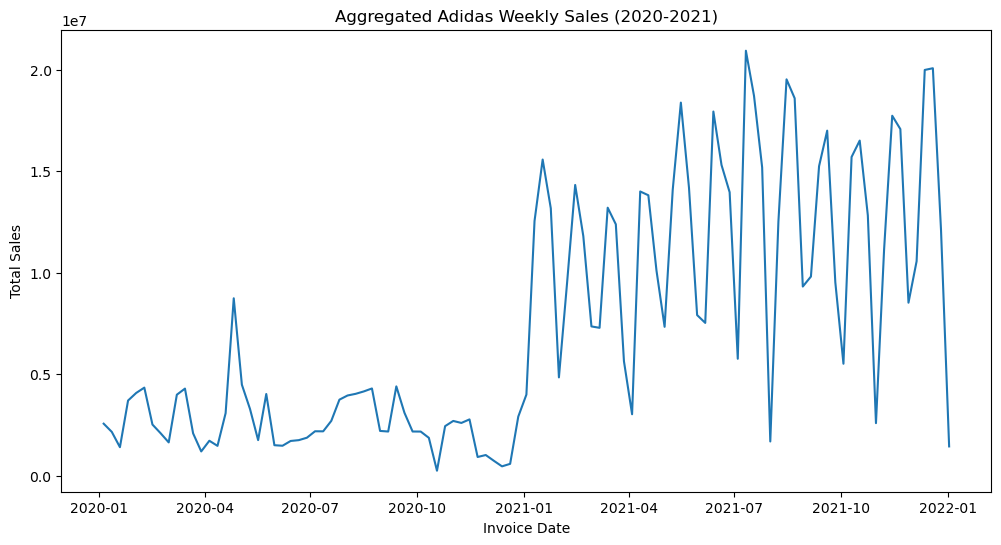

In [4]:
# Plot aggregated weekly sales
plt.figure(figsize=(12,6))
plt.plot(df_weekly.index, df_weekly['Total Sales'], label='Weekly Sales')
plt.title('Aggregated Adidas Weekly Sales (2020-2021)')
plt.xlabel('Invoice Date')
plt.ylabel('Total Sales')
plt.show()

## Train-Test Split

In [5]:
# Split data: 2020 for training, 2021 for testing
train = df_weekly[df_weekly.index.year == 2020]
test = df_weekly[df_weekly.index.year == 2021]

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (52, 1), Test shape: (52, 1)


In [6]:
# Display train set
train

,Total Sales
Invoice Date,
2020-01-05,2567533.0
2020-01-12,2162846.0
2020-01-19,1410638.0
2020-01-26,3708072.0
2020-02-02,4080689.0
2020-02-09,4342951.0
2020-02-16,2525124.0
2020-02-23,2098825.0
2020-03-01,1645795.0


In [7]:
# Display test set
test

,Total Sales
Invoice Date,
2021-01-03,4000584.0
2021-01-10,12547831.0
2021-01-17,15573346.0
2021-01-24,13173787.0
2021-01-31,4847087.0
2021-02-07,9485877.0
2021-02-14,14321907.0
2021-02-21,11803011.0
2021-02-28,7357121.0


## Traditional Forecasting Modelling

### ARIMA Model

In [8]:
# ARIMA(p,d,q) model
# Simple (1,1,1) order for baseline comparison
model_arima = ARIMA(train['Total Sales'], order=(1,1,1))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))

## SARIMA Model

In [9]:
# Auto-ARIMA Search for optimal parameters
# Using auto_arima to find optimal parameters. 
# We use m=12 as a more stable seasonal cycle for short datasets
stepwise_fit = auto_arima(train['Total Sales'],
                          start_p=1, start_q=1,
                          max_p=3, max_q=3,
                          m=12, 
                          seasonal=True,
                          d=1, D=0, 
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

optimal_order = stepwise_fit.order
optimal_seasonal_order = stepwise_fit.seasonal_order

print(f"Optimal SARIMA Order: {optimal_order}")
print(f"Optimal Seasonal Order: {optimal_seasonal_order}")

# SARIMA Model with Optimized Parameters
model_sarima = SARIMAX(train['Total Sales'].astype(float),
                        order=optimal_order,
                        seasonal_order=optimal_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)

# Forecast using SARIMA
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test)).predicted_mean

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1601.386, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1603.568, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1600.118, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1599.397, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1603.362, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1603.361, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1605.360, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1601.632, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1599.117, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1600.293, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1601.887, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1595.648, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1597.523, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[12]

## Performance Evaluation

In [10]:
def evaluate_forecast(y_true, y_pred, model_name='Model'):
    """
    Evaluate forecasting performance using multiple metrics:
    MSE, RMSE, MAE, R² Score
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}\n")

# Return metrics for the summary table
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
    }

# Collect results in a dictionary
results = {}
results['ARIMA'] = evaluate_forecast(test['Total Sales'], forecast_arima, 'ARIMA')
results['SARIMA'] = evaluate_forecast(test['Total Sales'], forecast_sarima, 'SARIMA')

# Present results in a DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Model'})

print("\n--- Final Model Performance Summary (Test Set) ---")
display(results_df.sort_values('RMSE'))

--- ARIMA ---
MSE: 118392381406159.52
RMSE: 10880826.32
MAE: 9715023.10
R² Score: -3.8231

--- SARIMA ---
MSE: 120655813397356.84
RMSE: 10984344.01
MAE: 9826584.21
R² Score: -3.9153


--- Final Model Performance Summary (Test Set) ---


,Model,MSE,RMSE,MAE,R² Score
0,ARIMA,1.183924e+14,1.088083e+07,9.715023e+06,-3.823114
1,SARIMA,1.206558e+14,1.098434e+07,9.826584e+06,-3.915322


## Visual Evaluation

### 1. Residual Plots: Visualize errors for each model

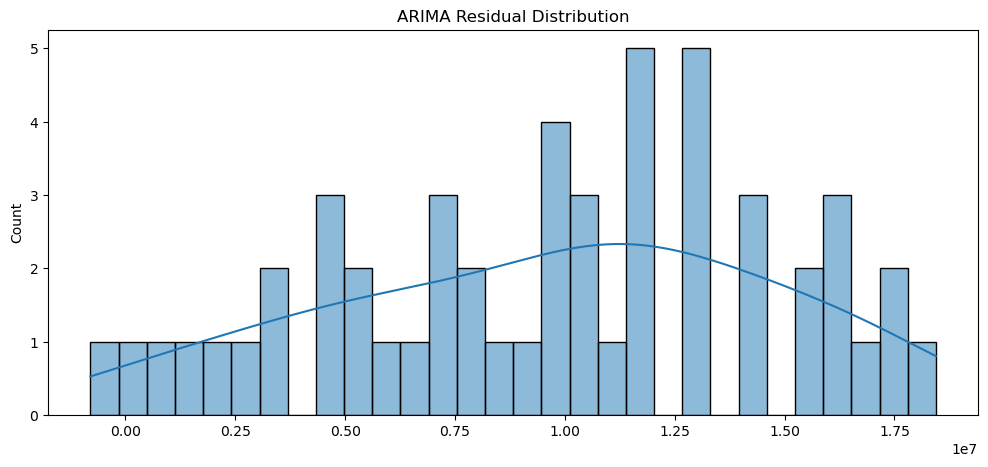

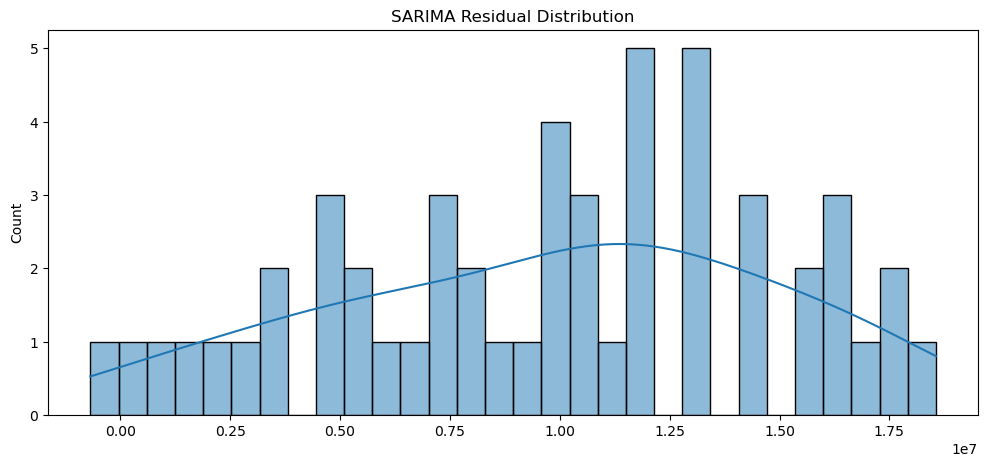

In [11]:
residuals_arima = test['Total Sales'] - forecast_arima
residuals_sarima = test['Total Sales'] - forecast_sarima

# ARIMA
plt.figure(figsize=(12,5))
sns.histplot(residuals_arima, kde=True, bins=30)
plt.title('ARIMA Residual Distribution')
plt.show()

# SARIMA
plt.figure(figsize=(12,5))
sns.histplot(residuals_sarima, kde=True, bins=30)
plt.title('SARIMA Residual Distribution')
plt.show()

### 2. Scatter Plots: Actual vs Predicted

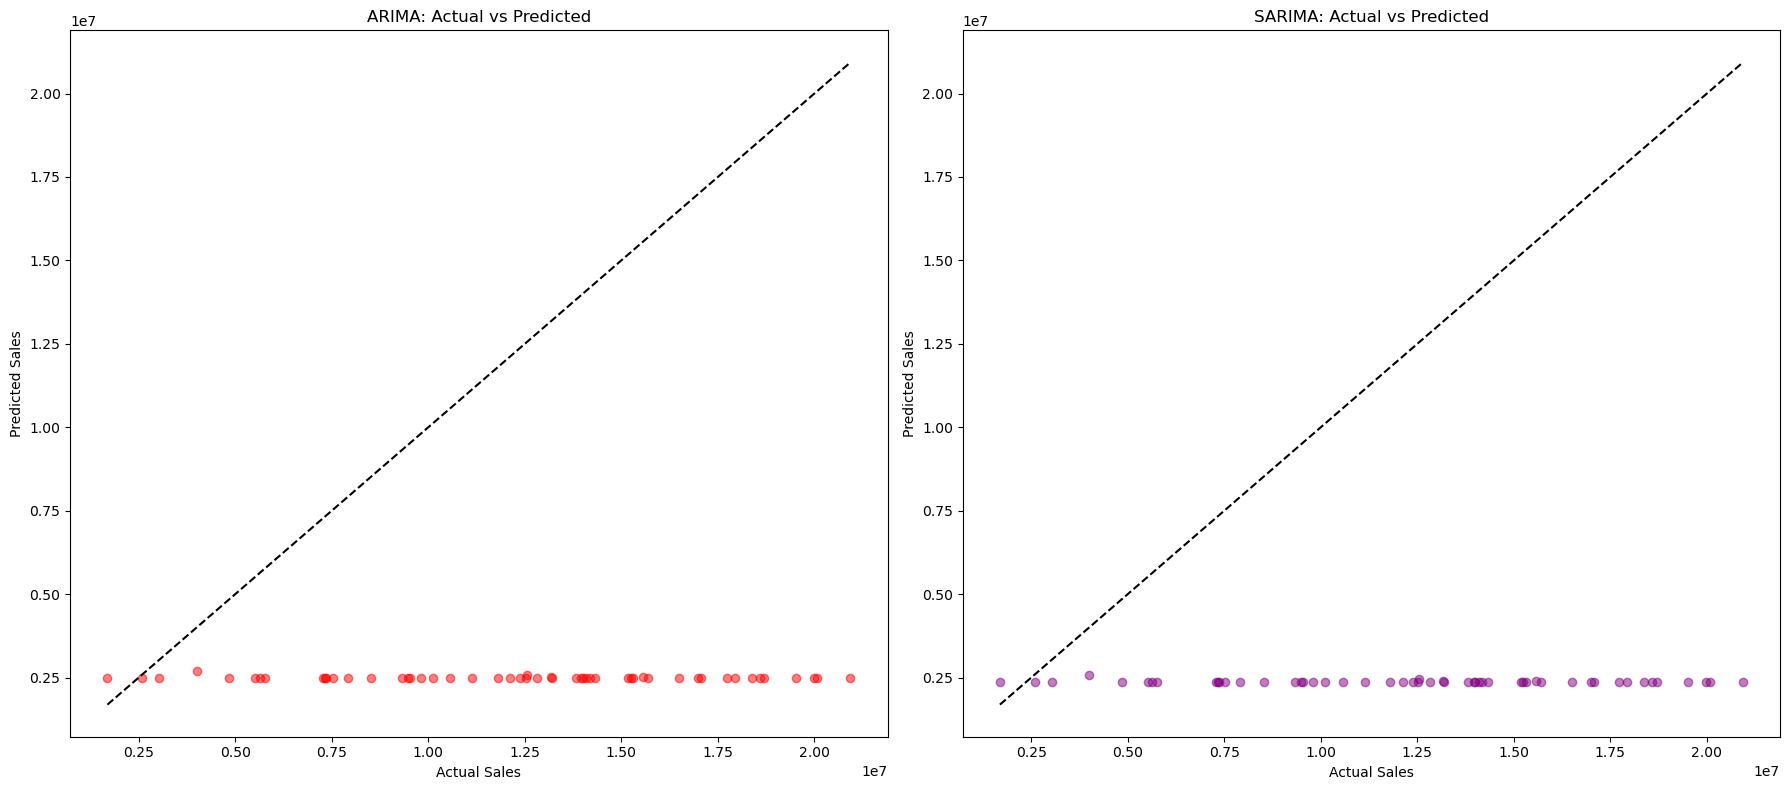

In [12]:
plt.figure(figsize=(18,8))

# ARIMA
plt.subplot(1,2,1)
plt.scatter(test['Total Sales'], forecast_arima, alpha=0.5, color='red')
plt.plot([test['Total Sales'].min(), test['Total Sales'].max()],
         [test['Total Sales'].min(), test['Total Sales'].max()], color='black', linestyle='--')
plt.title('ARIMA: Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

# SARIMA
plt.subplot(1,2,2)
plt.scatter(test['Total Sales'], forecast_sarima, alpha=0.5, color='purple')
plt.plot([test['Total Sales'].min(), test['Total Sales'].max()],
         [test['Total Sales'].min(), test['Total Sales'].max()], color='black', linestyle='--')
plt.title('SARIMA: Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

plt.tight_layout()
plt.show()

###  3. Line Plots: Time vs Forecast

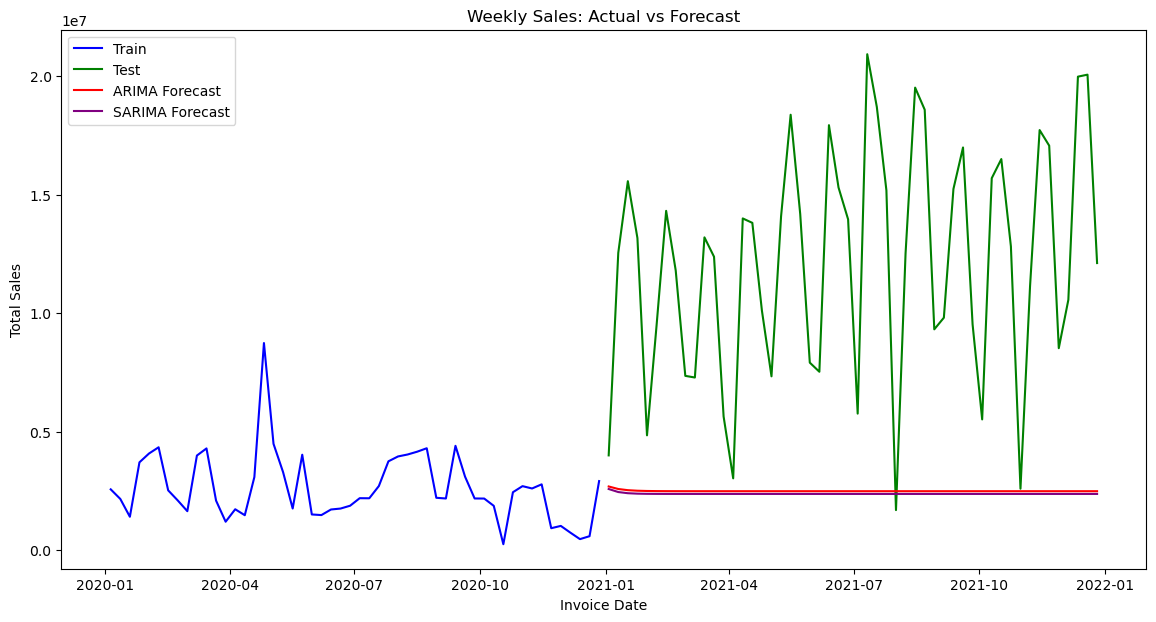

In [13]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Total Sales'], label='Train', color='blue')
plt.plot(test.index, test['Total Sales'], label='Test', color='green')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='purple')
plt.title('Weekly Sales: Actual vs Forecast')
plt.xlabel('Invoice Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()